# Terrestrial Laser Scanning of a Small Apple Tree with Leaf Flutter

Notebook: Hannah Weiser, 2023

This is a demonstration of scanning a [dynamic scene](https://github.com/3dgeo-heidelberg/helios/wiki/Dynamic-scenes), consisting of a tree with moving leaves.

We will use the command-line access of HELIOS++ to run the simulation, and use Python just for displaying the input XMLs and the resulting point clouds.

In [1]:
from pathlib import Path
from IPython.display import Code
from pyhelios.util.xmldisplayer import display_xml, find_playback_dir

In [2]:
import os

os.chdir("..")

## Scene

The scene was generated in [Blender](https://www.blender.org/) using three add-ons:
- [Sapling Tree Gen](https://docs.blender.org/manual/en/latest/addons/add_curve/sapling.html): This add-on allows to create trees using a set of parameters, using the algorithm by [Weber & Penn (1995)](https://doi.org/10.1145/218380.218427). For the resulting tree, the stem curve was converted to a mesh, and the leaves were [separated "By Loose Parts"](https://docs.blender.org/manual/en/latest/modeling/meshes/editing/mesh/separate.html). This way, each leaf can be moved individually.
- [Move Leaves](https://github.com/han16nah/movingtree_b2h/blob/main/addons/moveleaves.py): This add-on creates a leaf animation for a given tree (created by e.g., Sapling Tree Gen) by rotating the leaves around their leaf base. The user can provide an initial leaf angle distribution, the (random) fraction of leaves moving, the oscillation frequency and the normal distributions $N$($\mu$, $\sigma$), from which the three Euler rotation angles $X$, $Y$ and $Z$ will be sampled at each time step. In this case, half of the leaves are moving with an oscillation frequency of 6 and a rotation angle normal distribution $N(0°, 16°)$ for $X$ and  $N(0°, 4°)$ for $Y$ and $Z$.
- [DynScene2HELIOS](https://github.com/3dgeo-heidelberg/dyn_b2h): This add-on allows exporting dynamic Blender scenes (i.e., scenes with rigid motions) to HELIOS++ sceneparts and scenes. It considers translations and rotations.

This is what the Blender animation looks like:
![moving_tree](https://github.com/3dgeo-heidelberg/helios/blob/dev/img/example15.gif?raw=true "moving_tree")

Finally, further modifications were made:
- A wavefront material template library (MTL) was assigned (`leafwood.mtl`), which contains `helios_spectra` and `helios_classification` for the different materials (`Leaves` and `TrunksAndBranches`) to assign realistic reflectance values and to create an automatic classification of the output point cloud.

The exported dynamic scene is very large, but you can have a look [here](https://github.com/3dgeo-heidelberg/helios/blob/dev/data/scenes/movingtrees/tree10_a.xml). Let's have a look at how the sceneparts are configured.

### Static Scene Parts

For the static sceneparts, we simply load the 3D models from the corresponding OBJ files. For completeness, we also set the "up axis" to "z", which is also the HELIOS++ default.

```XML
<part>
    <filter type="objloader">
        <param type="string" key="filepath" value="data/sceneparts/tree1/tree.obj" />
        <param type="string" key="up" value="z" />
    </filter>
    
    
</part>
<part   >
    <filter type="objloader">
        <param type="string" key="filepath" value="data/sceneparts/tree1/leaves.obj" />
        <param type="string" key="up" value="z" />
    </filter>
    
</part>
```

### Dynamic Scene Parts

The dynamic sceneparts are much more complex. After loading the 3D model from a file, we are applying a sequence of rigid motions.

```XML
<part>
    <filter type="objloader">
        <param type="string" key="filepath" value="data/sceneparts/tree1/leaves.001.obj" />
        <param type="string" key="up" value="z" />
    </filter>
    
    <dmotion id="leaves.001_1" loop="1" next="leaves.001_2">
      <motion type="rotation" axis="-0.925;-0.125;-0.359" angle="17.02155541"
              center="0.02854790;0.03307739;0.82377845" autoCRS="1"/>
      <motion type="translation" vec="0.00000000;0.00000000;0.00000000"/>
    </dmotion>
    
    <dmotion id="leaves.001_2" loop="1" next="leaves.001_3">
      <motion type="rotation" axis="0.986;0.047;0.162" angle="48.94952399"
              center="0.02854790;0.03307739;0.82377845" autoCRS="1"/>
      <motion type="translation" vec="0.00000000;0.00000000;0.00000000"/>
    </dmotion>

....

    <dmotion id="leaves.001_30" loop="1" next="leaves.001_31">
      <motion type="rotation" axis="-0.943;0.319;0.099" angle="28.32427881"
              center="0.02854790;0.03307739;0.82377845" autoCRS="1"/>
      <motion type="translation" vec="0.00000000;0.00000000;0.00000000"/>
    </dmotion>
    
    <dmotion id="leaves.001_31" loop="1" next="leaves.001_1">
      <motion type="rotation" axis="0.878;-0.478;-0.020" angle="17.33759509"
              center="0.02854790;0.03307739;0.82377845" autoCRS="1"/>
      <motion type="translation" vec="0.00000000;0.00000000;0.00000000"/>
    </dmotion>
</part>
```

Within a rigid motion (`dmotion`), different motions can be combined. HELIOS++ supports translation, rotation, reflection, glide plane, helical motion and rotational symmetry (see [Dynamic scenes](https://github.com/3dgeo-heidelberg/helios/wiki/Dynamic-scenes)). The [DynScene2HELIOS](https://github.com/3dgeo-heidelberg/dyn_b2h) Blender add-on support translation and rotation, which can be seen in the XML syntax above.

Rotations are provided as `axis`-`angle` rotations, with angles in degrees. In addition a rotation center can be provided using the `center` parameter. The `autoCRS` parameter is used to automatically translate the rotation center to the internal reference system of the simulation.

Using the parameters `id` and `next`, individual rigid motions can be chained together. The `loop` parameter determines how often each motion is executed. If no `next` ID is provided, the motion sequence is terminated. In our case, we want to create a never ending loop, so we define the first motion as `next` in the last motion and set the rotation so that the leaf is back at its original orientation.

## Platform and Scanner

We are performing a terrestrial laser scanning (TLS) simulation from a static tripod with a RIEGL VZ-400. Platform and scanner are shown below:

In [3]:
Code(display_xml("python/pyhelios/data/platforms.xml", "tripod"), language="XML")

<platform id="tripod" name="TLS Tripod" type="static" drag="0">
		<scannerMount x="0" y="0" z="1.5">
		</scannerMount>
	</platform>

In [4]:
Code(
    display_xml("python/pyhelios/data/scanners_tls.xml", "riegl_vz400"), language="XML"
)

<scanner id="riegl_vz400" name="RIEGL VZ-400" accuracy_m="0.005" beamDivergence_rad="0.0003" headRotatePerSecMax_deg="60" optics="rotating" pulseFreqs_Hz="100000,300000" pulseLength_ns="5" rangeMin_m="1.5" scanAngleMax_deg="120" scanAngleEffectiveMax_deg="50" scanFreqMin_Hz="3" scanFreqMax_Hz="120">
		
		<FWFSettings beamSampleQuality="3" />	
		<beamOrigin x="0" y="0" z="0.2">
			<rot axis="y" angle_deg="0" />
			<rot axis="z" angle_deg="0" />
			<rot axis="x" angle_deg="0" />
		</beamOrigin>
		<headRotateAxis x="0" y="0" z="1" />
		
	</scanner>

## Survey

Six scan positions are created, regularly distributed on a circle around the tree. From each position, the scanner is pointing towards the tree and scans in a horizontal field of view of 90° and a vertical FOV of 100°. Vertical and horizontal resolution are set to 0.04 ° which corresponds to a point spacing of 7 mm at 10 m range.

In [5]:
Code(display_xml("data/surveys/dyn/tls_tree1_dyn.xml"), language="XML")

<document>
        <scannerSettings id="tls" active="true" pulseFreq_hz="600000" verticalResolution_deg="0.04" horizontalResolution_deg="0.04" />
        <survey name="tls_tree1_dyn" platform="data/platforms.xml#tripod" scanner="data/scanners_tls.xml#riegl_vz400" scene="data/scenes/dyn/tree1_dyn.xml#tree1">
            <leg>
            <platformSettings x="3.0000" y="0.0000" z="0" onGround="false" />
            <scannerSettings template="tls" headRotateStart_deg="45.0000" headRotateStop_deg="135.0000" trajectoryTimeInterval_s="0.05" />
        </leg>
        <leg>
            <platformSettings x="1.5000" y="2.5981" z="0" onGround="false" />
            <scannerSettings template="tls" headRotateStart_deg="105.0000" headRotateStop_deg="195.0000" trajectoryTimeInterval_s="0.05" />
        </leg>
        <leg>
            <platformSettings x="-1.5000" y="2.5981" z="0" onGround="false" />
            <scannerSettings template="tls" headRotateStart_deg="-195.0000" headRotateStop_deg="-105.0000" trajectoryTimeInterval_s="0.05" />
        </leg>
        <leg>
            <platformSettings x="-3.0000" y="0.0000" z="0" onGround="false" />
            <scannerSettings template="tls" headRotateStart_deg="-135.0000" headRotateStop_deg="-45.0000" trajectoryTimeInterval_s="0.05" />
        </leg>
        <leg>
            <platformSettings x="-1.5000" y="-2.5981" z="0" onGround="false" />
            <scannerSettings template="tls" headRotateStart_deg="-75.0000" headRotateStop_deg="15.0000" trajectoryTimeInterval_s="0.05" />
        </leg>
        <leg>
            <platformSettings x="1.5000" y="-2.5981" z="0" onGround="false" />
            <scannerSettings template="tls" headRotateStart_deg="-15.0000" headRotateStop_deg="75.0000" trajectoryTimeInterval_s="0.05" />
        </leg>
        
        </survey>
    </document>

## Running the Simulations

Let's run the simulation. Just for comparison, we are also running a simulation of a static version of the same scene.
The simulation of the dynamic scene will take considerably longer than the one with the static scene.

In [6]:
import time

In [7]:
start = time.time()
!helios data/surveys/dyn/tls_tree1_dyn.xml "--lasOutput" "--zipOutput" "-q" "--rebuildScene" "-j" "6"
duration_dyn = time.time() - start

In [8]:
start = time.time()
!helios data/surveys/dyn/tls_tree1_static.xml "--lasOutput" "--zipOutput" "-q" "--rebuildScene" "-j" "6"
duration_static = time.time() - start

In [9]:
print(f"""
Duration for dynamic simulation: {duration_dyn:6.1f} s
Duration for static simulation:  {duration_static:6.1f} s

On this system, dynamic simulations took {duration_dyn/duration_static:.1f} times longer.
""")


Duration for dynamic simulation:  705.5 s
Duration for static simulation:    25.4 s

On this system, dynamic simulations took 27.8 times longer.



## Loading the Simulated Point Clouds

We are loading the simulated point clouds and their attributes with [laspy](https://laspy.readthedocs.io/en/latest/) to `numpy` arrays and merge the individual scan positions.

In [10]:
import numpy as np
import laspy
import matplotlib.pyplot as plt

In [11]:
def read_pc(path, pt_src_id):
    las = laspy.read(path)
    pc = np.array([las.x, las.y, las.z]).T
    object_id = las["hitObjectId"]
    classification = las["classification"]
    pt_src_id = np.repeat(pt_src_id, pc.shape[0])

    return pc, object_id, classification, pt_src_id

In [12]:
# Dynamic point cloud
output_path = find_playback_dir("data/surveys/dyn/tls_tree1_dyn.xml")

print("Loading points from", Path(output_path))

pc_1, object_id_1, classification_1, pt_src_id_1 = read_pc(
    Path(output_path) / "leg000_points.laz", 1
)
pc_2, object_id_2, classification_2, pt_src_id_2 = read_pc(
    Path(output_path) / "leg001_points.laz", 2
)
pc_3, object_id_3, classification_3, pt_src_id_3 = read_pc(
    Path(output_path) / "leg002_points.laz", 3
)
pc_4, object_id_4, classification_4, pt_src_id_4 = read_pc(
    Path(output_path) / "leg003_points.laz", 4
)
pc_5, object_id_5, classification_5, pt_src_id_5 = read_pc(
    Path(output_path) / "leg004_points.laz", 5
)
pc_6, object_id_6, classification_6, pt_src_id_6 = read_pc(
    Path(output_path) / "leg005_points.laz", 6
)

print("Merging files")

pc = np.vstack((pc_1, pc_2, pc_3, pc_4, pc_5, pc_6))
object_id = np.hstack(
    (object_id_1, object_id_2, object_id_3, object_id_4, object_id_5, object_id_6)
)
classification = np.hstack(
    (
        classification_1,
        classification_2,
        classification_3,
        classification_4,
        classification_5,
        classification_6,
    )
)
pt_src_id = np.hstack(
    (pt_src_id_1, pt_src_id_2, pt_src_id_3, pt_src_id_4, pt_src_id_5, pt_src_id_6)
)

Loading points from E:\Software\_helios_versions\helios\output\tls_tree1_dyn\2024-05-28_18-53-35
Merging files


In [13]:
# Static point cloud
output_path_2 = find_playback_dir("data/surveys/dyn/tls_tree1_static.xml")

print("Loading points from", Path(output_path_2))

pc_s_1, object_id_s_1, classification_s_1, pt_src_id_s_1 = read_pc(
    Path(output_path_2) / "leg000_points.laz", 1
)
pc_s_2, object_id_s_2, classification_s_2, pt_src_id_s_2 = read_pc(
    Path(output_path_2) / "leg001_points.laz", 2
)
pc_s_3, object_id_s_3, classification_s_3, pt_src_id_s_3 = read_pc(
    Path(output_path_2) / "leg002_points.laz", 3
)
pc_s_4, object_id_s_4, classification_s_4, pt_src_id_s_4 = read_pc(
    Path(output_path_2) / "leg003_points.laz", 4
)
pc_s_5, object_id_s_5, classification_s_5, pt_src_id_s_5 = read_pc(
    Path(output_path_2) / "leg004_points.laz", 5
)
pc_s_6, object_id_s_6, classification_s_6, pt_src_id_s_6 = read_pc(
    Path(output_path_2) / "leg005_points.laz", 6
)

print("Merging files")

pc_s = np.vstack((pc_s_1, pc_s_2, pc_s_3, pc_s_4, pc_s_5, pc_s_6))
object_id_s = np.hstack(
    (
        object_id_s_1,
        object_id_s_2,
        object_id_s_3,
        object_id_s_4,
        object_id_s_5,
        object_id_s_6,
    )
)
classification_s = np.hstack(
    (
        classification_s_1,
        classification_s_2,
        classification_s_3,
        classification_s_4,
        classification_s_5,
        classification_s_6,
    )
)
pt_src_id_s = np.hstack(
    (
        pt_src_id_s_1,
        pt_src_id_s_2,
        pt_src_id_s_3,
        pt_src_id_s_4,
        pt_src_id_s_5,
        pt_src_id_s_6,
    )
)

Loading points from E:\Software\_helios_versions\helios\output\tls_tree1_static\2024-05-28_19-05-20
Merging files


## Visualization

First, let's plot the full point cloud, coloured by a) Object ID and b) Classification.

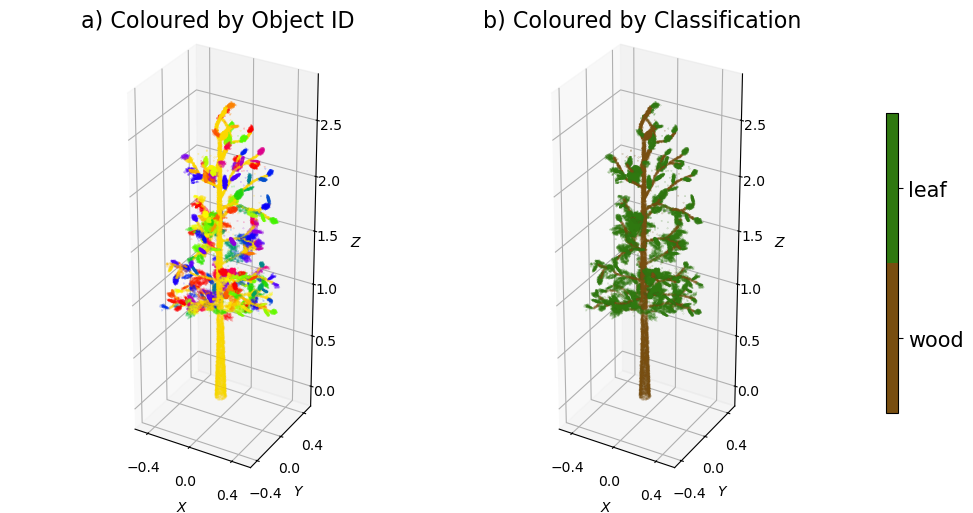

In [14]:
# Matplotlib figure
fig = plt.figure(figsize=(12, 6))

# First subplot
ax1 = fig.add_subplot(1, 2, 1, projection="3d", computed_zorder=False)
sc1 = ax1.scatter(
    pc[::10, 0],
    pc[::10, 1],
    pc[::10, 2],
    c=object_id[::10],
    cmap="prism",
    s=0.02,
    zorder=1,
)
ax1.set_title(label="a) Coloured by Object ID", fontsize=16, pad=20)

# Second subplot
from matplotlib.colors import LinearSegmentedColormap

colours = ["#784e10", "#2f7810"]
class_cmap = LinearSegmentedColormap.from_list("classification", colours, N=2)

ax2 = fig.add_subplot(1, 2, 2, projection="3d", computed_zorder=False)
sc2 = ax2.scatter(
    pc[::10, 0],
    pc[::10, 1],
    pc[::10, 2],
    c=classification[::10],
    cmap=class_cmap,
    s=0.02,
    zorder=1,
)
ax2.set_title(label="b) Coloured by Classification", fontsize=16, pad=20)

for ax in [ax1, ax2]:
    ax.set_xlabel("$X$")
    ax.set_ylabel("$Y$")
    ax.set_zlabel("$Z$", labelpad=15)
    ax.set_xticks([-0.4, 0, 0.4])
    ax.set_yticks([-0.4, 0, 0.4])
    # set equal axes
    box = (np.ptp(pc[:, 0]), np.ptp(pc[:, 1]), np.ptp(pc[:, 2]))
    ax.set_box_aspect(box)

# Adjust subplots
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8, wspace=0.02, hspace=0.02)
# Add color bar and set ticks and tick labels
cb_ax = fig.add_axes([0.83, 0.25, 0.01, 0.5])
tick_locs = [0.25, 0.75]
cbar = fig.colorbar(sc2, cax=cb_ax, ticks=tick_locs)
cbar.ax.set_yticklabels(["wood", "leaf"], fontsize=15)

# Display results
plt.show()

Next, we zoom in a bit to see more detail and compare the static to the moving point cloud.

In [15]:
# Select a subset of the point cloud
def clip_by_bb(pts, xmin, xmax, ymin, ymax, zmin, zmax):
    clip_index = (
        (pts[:, 0] > xmin)
        & (pts[:, 0] < xmax)
        & (pts[:, 1] > ymin)
        & (pts[:, 1] < ymax)
        & (pts[:, 2] > zmin)
        & (pts[:, 2] < zmax)
    )
    return clip_index


# clip static point cloud
clip_idx = clip_by_bb(pc_s, -0.21, 0.116, -0.317, 0.02, 1.7, 1.88)
pc_s_clipped = pc_s[clip_idx]
pt_src_id_s_clipped = pt_src_id_s[clip_idx]
object_id_s_clipped = object_id_s[clip_idx]

# clip dynamic point cloud and additionally filter by object ids (which are in static point cloud)
clip_idx = clip_by_bb(pc, -0.21, 0.116, -0.317, 0.02, 1.7, 1.88)
oid_idx = np.isin(object_id, list(set(object_id_s_clipped)))
clip_and_oid_idx = np.logical_and(clip_idx, oid_idx)
pc_clipped = pc[clip_and_oid_idx]
pt_src_id_clipped = pt_src_id[clip_and_oid_idx]
object_id_clipped = object_id[clip_and_oid_idx]

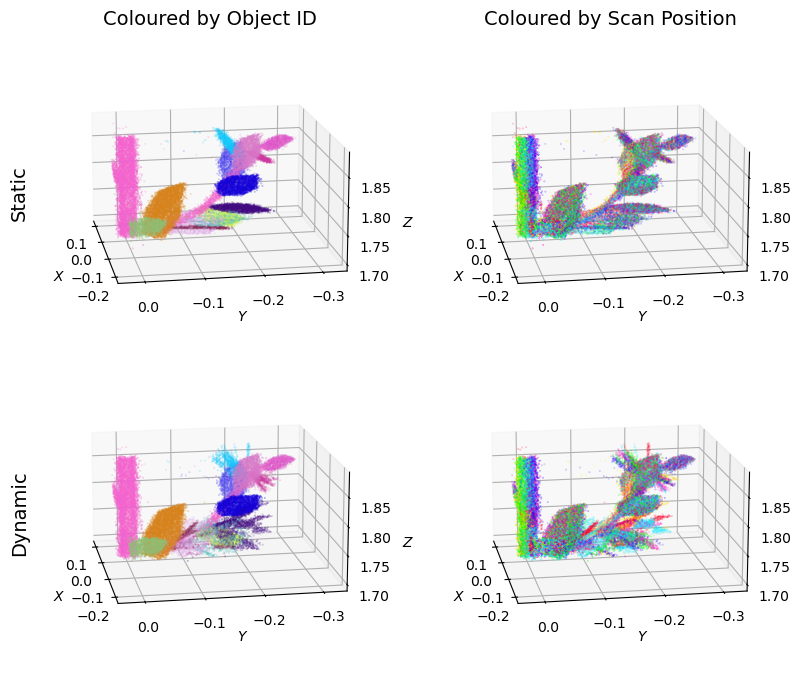

In [16]:
# Matplotlib figure
fig = plt.figure(figsize=(10, 8))

# random color map
cmap = plt.cm.colors.ListedColormap(np.random.rand(256, 3))

# First subplot
ax1 = fig.add_subplot(2, 2, 1, projection="3d", computed_zorder=False)
sc1 = ax1.scatter(
    pc_s_clipped[:, 0],
    pc_s_clipped[:, 1],
    pc_s_clipped[:, 2],
    c=object_id_s_clipped,
    cmap=cmap,
    s=0.05,
    zorder=1,
)
ax1.set_title(label="Coloured by Object ID", fontsize=14)
# Second subplot

ax2 = fig.add_subplot(2, 2, 2, projection="3d", computed_zorder=False)
sc2 = ax2.scatter(
    pc_s_clipped[:, 0],
    pc_s_clipped[:, 1],
    pc_s_clipped[:, 2],
    c=pt_src_id_s_clipped,
    cmap="gist_rainbow",
    s=0.05,
    zorder=1,
)
ax2.set_title(label="Coloured by Scan Position", fontsize=14)

# Third subplot
ax3 = fig.add_subplot(2, 2, 3, projection="3d", computed_zorder=False)
sc3 = ax3.scatter(
    pc_clipped[:, 0],
    pc_clipped[:, 1],
    pc_clipped[:, 2],
    c=object_id_clipped,
    cmap=cmap,
    s=0.05,
    zorder=1,
)
# ax3.set_title(label='c) Coloured by Object ID', fontsize=14)

# Fourth subplot
ax4 = fig.add_subplot(2, 2, 4, projection="3d", computed_zorder=False)
sc4 = ax4.scatter(
    pc_clipped[:, 0],
    pc_clipped[:, 1],
    pc_clipped[:, 2],
    c=pt_src_id_clipped,
    cmap="gist_rainbow",
    s=0.05,
    zorder=1,
)
# ax4.set_title(label='d) Coloured by Scan Position', fontsize=14)

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlabel("$X$")
    ax.set_ylabel("$Y$")
    ax.set_zlabel("$Z$")
    box = (np.ptp(pc_clipped[:, 0]), np.ptp(pc_clipped[:, 1]), np.ptp(pc_clipped[:, 2]))
    ax.set_box_aspect(box)
    ax.view_init(elev=15, azim=170)

fig.text(
    0.1,
    0.7,
    "Static",
    rotation="vertical",
    va="center",
    transform=fig.transFigure,
    fontsize=14,
)
fig.text(
    0.1,
    0.3,
    "Dynamic",
    rotation="vertical",
    va="center",
    transform=fig.transFigure,
    fontsize=14,
)
# Adjust subplots
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, wspace=0.0, hspace=0.0)

# Display results
plt.show()

Let's have a look at a few of the leaves, some of which are static and some of which are moving.

In [17]:
moving_leaves = [35, 57, 63, 73, 89, 124, 125, 130]
static_leaves = [167, 189, 195, 200, 220, 242, 251, 260]

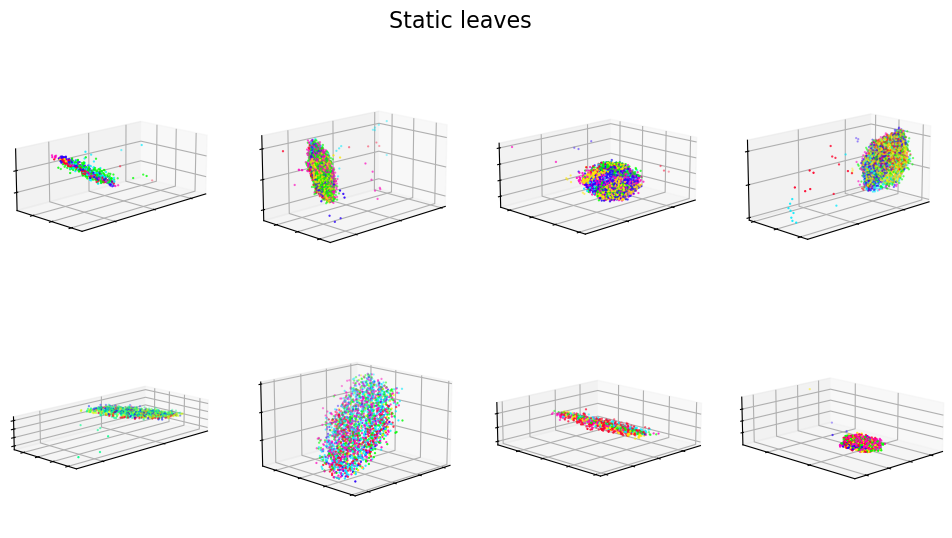

In [18]:
fig = plt.figure(figsize=(12, 6))

for i, leaf_id in enumerate(static_leaves):
    sel_idx = object_id == leaf_id
    pc_sel = pc[sel_idx]
    pt_src_id_sel = pt_src_id[sel_idx]

    ax = fig.add_subplot(2, 4, i + 1, projection="3d", computed_zorder=False)
    sc = ax.scatter(
        pc_sel[:, 0],
        pc_sel[:, 1],
        pc_sel[:, 2],
        c=pt_src_id_sel,
        cmap="gist_rainbow",
        s=0.4,
        zorder=1,
    )
    ax.tick_params(labelbottom=False, labelleft=False)
    ax.view_init(elev=15, azim=45)
    # set equal axes
    box = (np.ptp(pc_sel[:, 0]), np.ptp(pc_sel[:, 1]), np.ptp(pc_sel[:, 2]))
    ax.set_box_aspect(box)
fig.suptitle("Static leaves", fontsize=16)
plt.show()

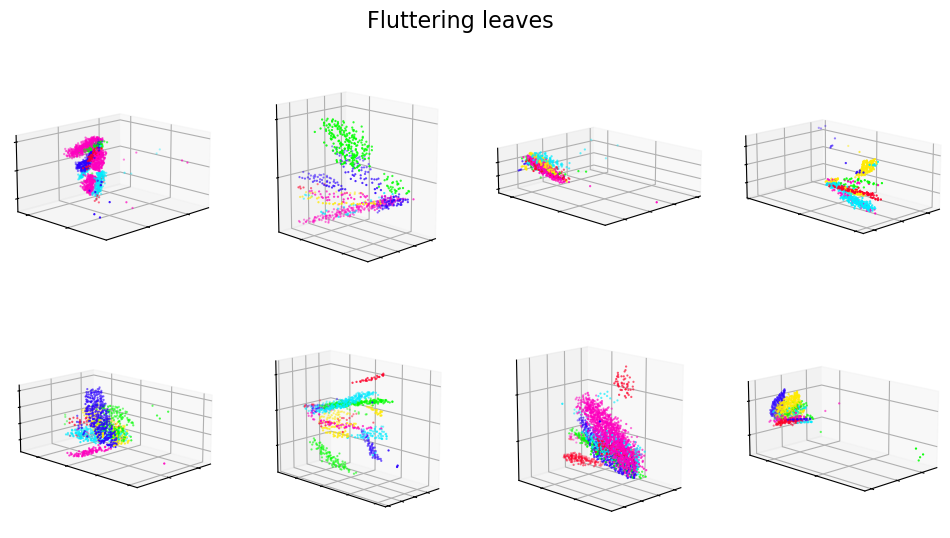

In [19]:
fig = plt.figure(figsize=(12, 6))

for i, leaf_id in enumerate(moving_leaves):
    sel_idx = object_id == leaf_id
    pc_sel = pc[sel_idx]
    pt_src_id_sel = pt_src_id[sel_idx]

    ax = fig.add_subplot(2, 4, i + 1, projection="3d", computed_zorder=False)
    sc = ax.scatter(
        pc_sel[:, 0],
        pc_sel[:, 1],
        pc_sel[:, 2],
        c=pt_src_id_sel,
        cmap="gist_rainbow",
        s=0.4,
        zorder=1,
    )

    ax.tick_params(labelbottom=False, labelleft=False)
    ax.view_init(elev=15, azim=45)
    # set equal axes
    box = (np.ptp(pc_sel[:, 0]), np.ptp(pc_sel[:, 1]), np.ptp(pc_sel[:, 2]))
    ax.set_box_aspect(box)
fig.suptitle("Fluttering leaves", fontsize=16)
plt.show()